In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from models.encodetocontact import DLEM
import torch
from util import train_w_signal, diagonal_normalize, plot_results
from matplotlib.patches import Patch

In [2]:
import colorcet as cc

In [3]:
dev = torch.device('cuda')

In [4]:
def plot_corr(mat):
    seaborn.heatmap(np.corrcoef(mat))

In [5]:
def plot_map_diff(map1, map2, signal1d1, signal1d2, label1, label2, start, stop, color_lookup, axes=None):
    if axes is None:
        _, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8.5),
                               sharex='col',
                               sharey='row',
                               gridspec_kw={'wspace':0,
                                           'hspace':0,
                                           'height_ratios':[1,2]})
    map1 = map1[start:stop, start:stop]
    map2 = map2[start:stop, start:stop]
    signal1d1 = signal1d1[start:stop]
    signal1d2 = signal1d2[start:stop]
    for i, map in enumerate([map1, map2, np.abs(map1 - map2)]):
        axes[1,i].matshow(map, cmap="icefire")
        axes[1,i].xaxis.set_ticks_position('bottom')
        axes[1,i].xaxis.set_label_position('bottom')
    for i, (s, l) in enumerate(zip([signal1d1, signal1d2, np.hstack([signal1d1, signal1d2])],
                              [label1, label2, np.concatenate([label1, label2])])):
        for c in range(s.shape[1]):
            axes[0,i].plot(s[:,c], color=color_lookup[l[c]])

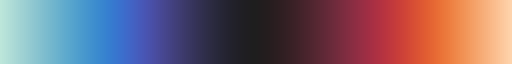

In [6]:
seaborn.color_palette("icefire", as_cmap=True)

In [7]:
chromosome = "chr10"
start = 13600000
resolution = 8000
stop = start + resolution * 100#14400000
offset = 0 #1000
start_binned = start//resolution + offset
stop_binned = stop//resolution + offset

In [8]:
f"{chromosome}:{start}-{stop}"

'chr10:13600000-14400000'

In [9]:
map_h1 = np.load(".data/ForGrant/chr10_8k_H1.npy")[:-1, :-1]
map_hff = np.load(".data/ForGrant/chr10_8k_HFF.npy")[:-1, :-1]

In [10]:
map_h1[np.isnan(map_h1)] = 0
map_hff[np.isnan(map_hff)] = 0

In [34]:
encode = pd.read_csv(".data/ForGrant/bestTracksBinned.txt", sep="\t").iloc[:, [1, 2, 3, 8, 9, 10, 11]]

In [35]:
encode

,#Chromosome,Start,End,MaxSignal_HFF_CTCF_ENCFF406SZM.bigWig,MaxSignal_HFF_DNAse_ENCFF684SBL.bigWig,MaxSignal_H1_CTCF_ENCFF038RVZ.bigWig,MaxSignal_H1_DNAse_ENCFF232GUZ.bigWig
0,chr10,0.0,8000.0,0.000000,0.128977,0.000000,0.128945
1,chr10,8000.0,16000.0,3.447080,1.046909,8.096821,15.204382
2,chr10,16000.0,24000.0,0.100814,0.323581,0.055098,0.128945
3,chr10,24000.0,32000.0,0.194384,0.332207,0.055098,0.413623
4,chr10,32000.0,40000.0,0.100814,0.128977,0.055098,0.498969
...,...,...,...,...,...,...,...
16719,chr10,133752000.0,133760000.0,0.000000,0.128977,0.000000,0.128945
16720,chr10,133760000.0,133768000.0,3.648037,1.687513,0.316923,0.498969
16721,chr10,133768000.0,133776000.0,0.194384,0.332207,0.055098,0.323581
16722,chr10,133776000.0,133784000.0,0.313183,0.332207,0.055098,0.323581


In [36]:
encode = encode.loc[encode["#Chromosome"] == "chr10"]

In [37]:
signal_names = encode.columns[3:]

In [38]:
signal_names

Index(['MaxSignal_HFF_CTCF_ENCFF406SZM.bigWig',
       'MaxSignal_HFF_DNAse_ENCFF684SBL.bigWig',
       'MaxSignal_H1_CTCF_ENCFF038RVZ.bigWig',
       'MaxSignal_H1_DNAse_ENCFF232GUZ.bigWig'],
      dtype='object')

In [16]:
h1_ii = np.array([n.split("_")[1] == "H1" for n in signal_names])

In [17]:
encode = encode.to_numpy()[:, 3:].astype(float)

In [18]:
encode = (encode - encode.mean(axis=0)[np.newaxis])/(encode.std(axis=0)[np.newaxis])

In [19]:
encode_h1 = encode[:, h1_ii]

In [20]:
encode_hff = encode[:, np.logical_not(h1_ii)]

Finally read the CTCF orientations.

In [21]:
ctcf_neg = pd.read_csv("../loopExtraction/data/ctcf/MA0139.1.neg.score.sorted.bedgraph", sep="\t", header=None)
ctcf_pos = pd.read_csv("../loopExtraction/data/ctcf/MA0139.1.pos.score.sorted.bedgraph", sep="\t", header=None)

In [22]:
def sub_select_bed(bed, chr, start, stop):
    return bed.iloc[np.logical_and(np.logical_and(bed.iloc[:,0] == chr,
                                                  bed.iloc[:,1] >= start),
                                                  bed.iloc[:,2] <= stop).to_numpy()]

In [23]:
def return_vec_from_bed(bed, n):
    out = np.zeros(n)
    for ro in bed.iloc[:,1:].to_numpy(dtype=int):
        out[ro[0]:(ro[1]+1)] = np.maximum(out[ro[0]:(ro[1]+1)], np.ones((ro[1]+1) - ro[0])*ro[2])
    return out

In [24]:
ctcf_neg = sub_select_bed(ctcf_neg, chromosome, 0, 1e10)
ctcf_neg[1] = ctcf_neg[1] // resolution
ctcf_neg[2] = ctcf_neg[2] // resolution 
ctcf_neg_vec = return_vec_from_bed(ctcf_neg, encode_h1.shape[0])
ctcf_neg_vec = (ctcf_neg_vec - np.mean(ctcf_neg_vec))/np.std(ctcf_neg_vec)

In [25]:
ctcf_pos = sub_select_bed(ctcf_pos, chromosome, 0, 1e10)
ctcf_pos[1] = ctcf_pos[1] // resolution
ctcf_pos[2] = ctcf_pos[2] // resolution
ctcf_pos_vec = return_vec_from_bed(ctcf_pos, encode_h1.shape[0])
ctcf_pos_vec = (ctcf_pos_vec - np.mean(ctcf_pos_vec))/np.std(ctcf_pos_vec)

In [26]:
encode_h1 = np.hstack([encode_h1, ctcf_neg_vec[:,np.newaxis], ctcf_pos_vec[:,np.newaxis]])

In [27]:
encode_hff = np.hstack([encode_hff, ctcf_neg_vec[:,np.newaxis], ctcf_pos_vec[:,np.newaxis]])

In [28]:
signal_names_h1 = np.array(['DNAse', 'CTCF', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K27ac', 'CTCF_neg', 'CTCF_pos'])
signal_names_hff = np.array(['CTCF', 'DNAse', 'CTCF', 'H3K27me3', 'H3K4me1', 'H3K27ac', 'H3K4me3', 'CTCF_neg', 'CTCF_pos'])
signal_unique = np.unique(np.concatenate([signal_names_h1, signal_names_hff]))
color_n = len(signal_unique)
palette = seaborn.color_palette(cc.glasbey, n_colors=color_n)
color_dict = {sig:palette[n] for n, sig in enumerate(signal_unique)}

In [29]:
encode_h1.shape, map_h1.shape, encode_hff.shape, map_hff.shape 

((16724, 6), (16724, 16724), (16724, 6), (16724, 16724))

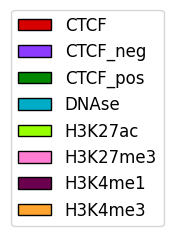

In [30]:
# Create a list of patches for the legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for label, color in color_dict.items()]

# Create the legend
plt.figure(figsize=(2, 2))  # Adjust figure size if necessary
plt.legend(handles=legend_elements, loc='center', fontsize='large')#, title='Labels Legend')
plt.axis('off')  # Hide axes
plt.show()

In [31]:
select_ii_h1 = np.logical_or(signal_names_h1 == "CTCF", signal_names_h1 == "CTCF_neg")
select_ii_h1 = np.logical_or(select_ii_h1, signal_names_h1 == "CTCF_pos")
select_ii_hff = np.logical_or(signal_names_hff == "CTCF", signal_names_hff == "DNAse")
select_ii_hff = np.logical_or(select_ii_hff, signal_names_hff == "CTCF_neg")
#fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
plot_map_diff(map_h1, map_hff,
              encode_h1[:, select_ii_h1], encode_hff[:, select_ii_hff],
              signal_names_h1[select_ii_h1], signal_names_hff[select_ii_hff],
              start_binned, stop_binned, color_dict)
#plot_map_diff(map_h1, map_hff,
#              encode_h1, encode_hff,
#              signal_names_h1, signal_names_hff,
#              start_binned, stop_binned, color_dict)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 6 but corresponding boolean dimension is 8

In [ ]:
model = DLEM(encode_hff.shape[-1])

In [ ]:
encode_tmp = torch.tensor(encode_hff[start_binned:stop_binned][np.newaxis], dtype=torch.float32)
map_tmp = map_hff[start_binned:stop_binned,start_binned:stop_binned]

In [ ]:
pred_map = model.contact_map_prediction(encode_tmp, torch.ones((1, encode_tmp.shape[1])) * encode_tmp.shape[1])

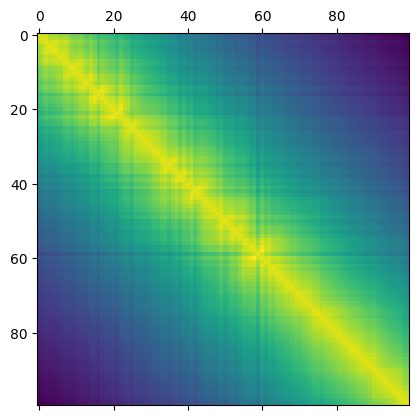

In [ ]:
plt.matshow(pred_map[0])

In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1000, mode="max")
diag_start = 3
diag_stop = 50

In [ ]:
mat_tmp = torch.tensor(diagonal_normalize(map_tmp)[np.newaxis], dtype=torch.float32)

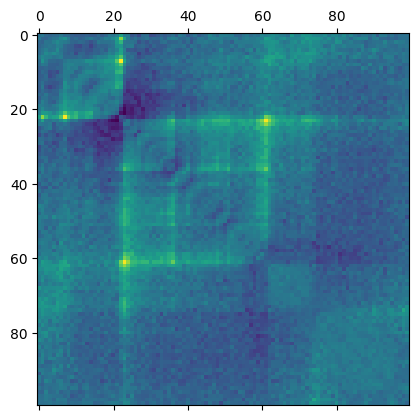

In [ ]:
plt.matshow(mat_tmp[0])

In [ ]:
mat_tmp.shape, encode_tmp.shape

(torch.Size([1, 100, 100]), torch.Size([1, 100, 9]))

In [ ]:
best_loss_model, best_corr_model, arr_loss, arr_corr = train_w_signal(model,
                                                                      optimizer,
                                                                      scheduler,
                                                                      torch.nn.MSELoss(reduction="sum"),
                                                                      torch.exp(mat_tmp),
                                                                      encode_tmp,
                                                                      diag_start,
                                                                      diag_stop,
                                                                      dev,
                                                                      num_epoch=1500)

/data/src/loopextrusion_pytorch/util.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(dev)


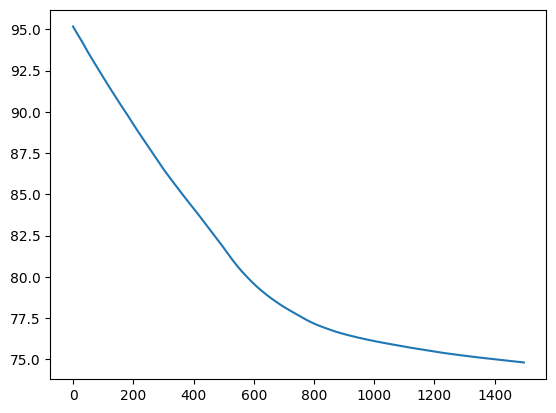

In [ ]:
plt.plot(arr_loss[2:])

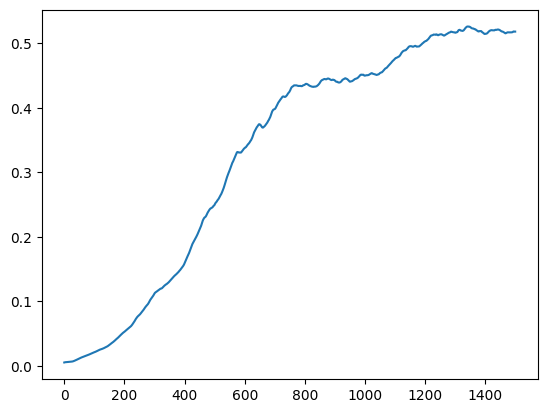

In [ ]:
plt.plot(arr_corr)

In [ ]:
pred_map = best_corr_model.cpu().contact_map_prediction(encode_tmp, torch.ones((1, encode_tmp.shape[1])) * encode_tmp.shape[1]).detach().cpu().numpy()

In [ ]:
pred_map = diagonal_normalize(np.log(pred_map[0]))

In [ ]:
with torch.no_grad():
    out = best_corr_model.cpu().converter(encode_tmp.transpose(-2,-1)).cpu().detach().numpy()

In [ ]:
p_l = out[0,0,:]
p_r = out[0,1,:]

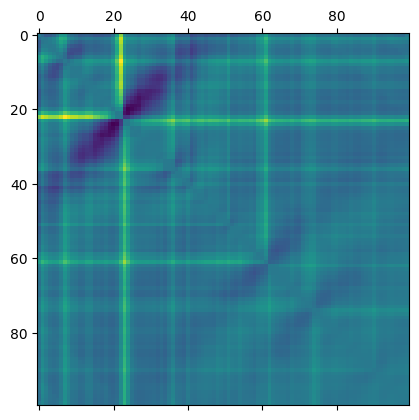

In [ ]:
plt.matshow(pred_map)

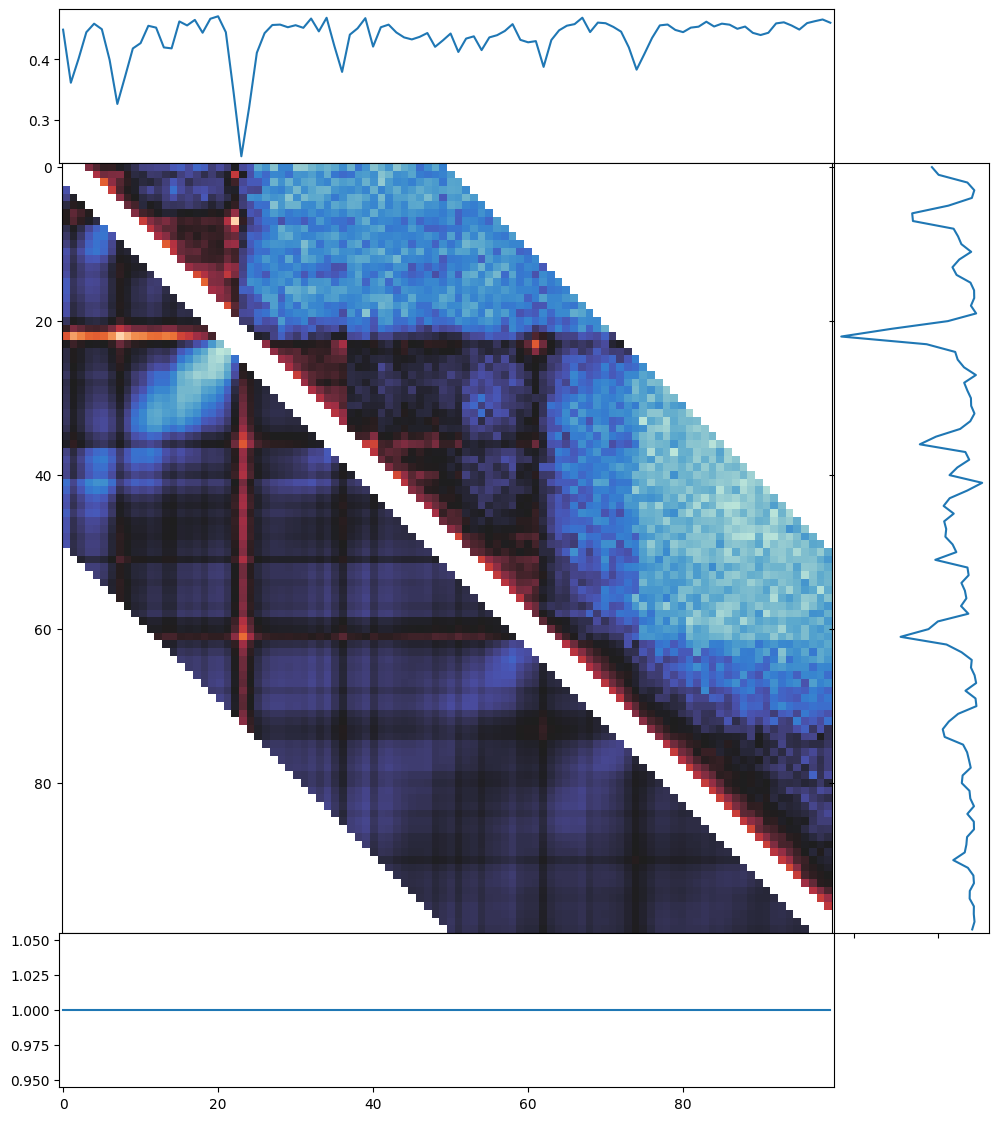

In [ ]:
plot_results(map_tmp, pred_map, (p_l, p_r, np.ones_like(p_l)), ignore_i_off=diag_stop)